## Notebook for cleaning the MesoWest weather station data

Author: Wenwen Kong

Updated: 2022-07-12

### About the data
- We focus on five stations in total: KBUR, KCQT, KLAX, KSMO, KVNY
- Data is downloaded from the MesoWest website
- Time period spans 2005 to 2021, and only covers daily data during boreal summer (June to August)
- Example data of KLAX can be found in the github repo where this notebook locates:
    - Downloaded raw data:
        - ./KLAX/24_Hr_High_Temperature/June_2005-2021/*.csv
        - ./KLAX/24_Hr_High_Temperature/July_2005-2021/*.csv
        - ./KLAX/24_Hr_High_Temperature/August_2005-2021/*.csv
        
    - Processed data:

### Purpose of this notebook: 
- Step 1 Connect the June, July, August files
- Step 2 Clean the data by (1) removing duplicates and (2) dealing with missing values
- Step 3 Basic visualization 

### Helpful methods used in this notebook
- pd.dropna()
- pd.to_datetime()
- pd.to_numeric()
- pd.set_index()
- pd.date_range(start=, end=).difference()
- ... ... 

### Load useful libraries 

In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

### Data cleaning 

In [2]:
# ***************************************
#      Set up parameters
# ***************************************

years           = list(range(2005, 2022)) 
days_of_summer  = 92
station         = ['KBUR', 'KCQT', 'KLAX', 'KSMO', 'KVNY']
months          = ['June', 'July', 'August']
var_folder      = '24_Hr_High_Temperature'
var_oldname     = 'air_temp_high_24_hour_set_1'
var_name        = 'Tmax'

# ***************************************
#      Loop through the stations
# ***************************************
for site in station:      
    print("*********************************************************")
    print("******* station = "+site+"  ***********")
    print("*********************************************************")
    # ----- all_dfs is used to store the whole time series 
    all_dfs     = []
        
    # *********************************************************
    #    Loop through the range of year 2005 to year 2021
    # *********************************************************
    for year in years:
        # ---- summer_df is used to store the June to August connected time series 
        summer_df       = []
        for month in months:
            # ---- read in the .csv file
            path        = './'+site+'/'+var_folder+'/'+month+'_2005-2021/'+site+'_'+month+'_'+str(year)+'.csv'
            file        = pd.read_csv(path, skiprows=6, usecols = ['Date_Time', var_oldname])
                    
            # ---- drop all the NaN values
            file_clean  = file.dropna()
                    
            # ---- append to the summer_df
            summer_df.append(file_clean)
                
        # ---- concatenate 
        df      = pd.concat(summer_df)
                
        # ---- rename the column names for simplicity 
        df.rename(columns = {'Date_Time':'DateTime',var_oldname : var_name}, inplace = True)
                
        # ---- reformat the DateTime column to only keep yyyy-mm-dd
        df['DateTime'] = pd.to_datetime(df['DateTime'])
        df['DateTime'] = df['DateTime'].dt.date 
    
        # ---- remove duplicated dates  
        # print(df.index.is_unique)
        # print(df.index.duplicated())
        df.drop_duplicates(subset='DateTime', keep = False, inplace = True)
    
        # ---- convert the 'Tmax' from string to numeric
        df[var_name] = pd.to_numeric(df[var_name])
    
        # *********************************************************
        #    Deal with the missing dates
        # *********************************************************
        if len(df[var_name]) < days_of_summer:
            print("--------------------------------------------------------------------")
            print("Year "+str(year)+" has "+str(days_of_summer - len(df[var_name]))+" missing days")
            
            df           = df.set_index('DateTime')
            df.index     = pd.to_datetime(df.index)
        
            date_range   = pd.date_range(start=str(year)+"-06-01", end=str(year)+"-08-31")
            print(date_range.difference(df.index))
        
            # ---- fill in the missing dates with a missing value
            df           = df.reindex(date_range, fill_value=np.nan)
                
        # *********************************************************
        #    Create a 'DateTime' column 
        # *********************************************************
        df['DateTime'] = pd.to_datetime(pd.date_range(start=str(year)+"-06-01", end=str(year)+"-08-31"))
        df.to_csv('./'+site+'/'+var_folder+'/'+site+'_'+var_name+'_June-July-August_'+str(year)+'.csv')

*********************************************************
******* station = KBUR  ***********
*********************************************************
--------------------------------------------------------------------
Year 2005 has 1 missing days
DatetimeIndex(['2005-06-12'], dtype='datetime64[ns]', freq=None)
--------------------------------------------------------------------
Year 2006 has 1 missing days
DatetimeIndex(['2006-08-10'], dtype='datetime64[ns]', freq=None)
--------------------------------------------------------------------
Year 2007 has 1 missing days
DatetimeIndex(['2007-07-10'], dtype='datetime64[ns]', freq=None)
--------------------------------------------------------------------
Year 2008 has 1 missing days
DatetimeIndex(['2008-07-10'], dtype='datetime64[ns]', freq=None)
--------------------------------------------------------------------
Year 2009 has 2 missing days
DatetimeIndex(['2009-06-26', '2009-07-29'], dtype='datetime64[ns]', freq=None)
-------------------

--------------------------------------------------------------------
Year 2014 has 8 missing days
DatetimeIndex(['2014-06-12', '2014-07-10', '2014-07-14', '2014-07-27',
               '2014-07-28', '2014-08-07', '2014-08-08', '2014-08-25'],
              dtype='datetime64[ns]', freq=None)
--------------------------------------------------------------------
Year 2015 has 1 missing days
DatetimeIndex(['2015-06-17'], dtype='datetime64[ns]', freq=None)
--------------------------------------------------------------------
Year 2016 has 2 missing days
DatetimeIndex(['2016-06-01', '2016-06-22'], dtype='datetime64[ns]', freq=None)
--------------------------------------------------------------------
Year 2018 has 3 missing days
DatetimeIndex(['2018-06-12', '2018-06-27', '2018-06-28'], dtype='datetime64[ns]', freq=None)
--------------------------------------------------------------------
Year 2020 has 3 missing days
DatetimeIndex(['2020-08-01', '2020-08-03', '2020-08-04'], dtype='datetime64[ns]',

### In the data cleaning step, we save each summer to one .csv file
### We now create a holistic file that contains all summers

In [3]:
for site in station:
    all_dfs = []
    
    for year in years:
        file    = './'+site+'/'+var_folder+'/'+site+'_'+var_name+'_June-July-August_'+str(year)+'.csv'
        new_df  = pd.read_csv(file, usecols=['DateTime', var_name])
        all_dfs.append(new_df)
    
    all_dfs_concat = pd.concat(all_dfs)
    saveto = './'+site+'/'+var_folder+'/'+site+'_'+var_name+'_June-July-August_'+str(years[0])+'-'+str(years[-1])+'.csv'
    all_dfs_concat.to_csv(saveto)
    
    print('---- '+site+' ---- done')

---- KBUR ---- done
---- KCQT ---- done
---- KLAX ---- done
---- KSMO ---- done
---- KVNY ---- done


### Some basic visualization 

(array([ 60.,  70.,  80.,  90., 100., 110., 120.]),
 <a list of 7 Text yticklabel objects>)

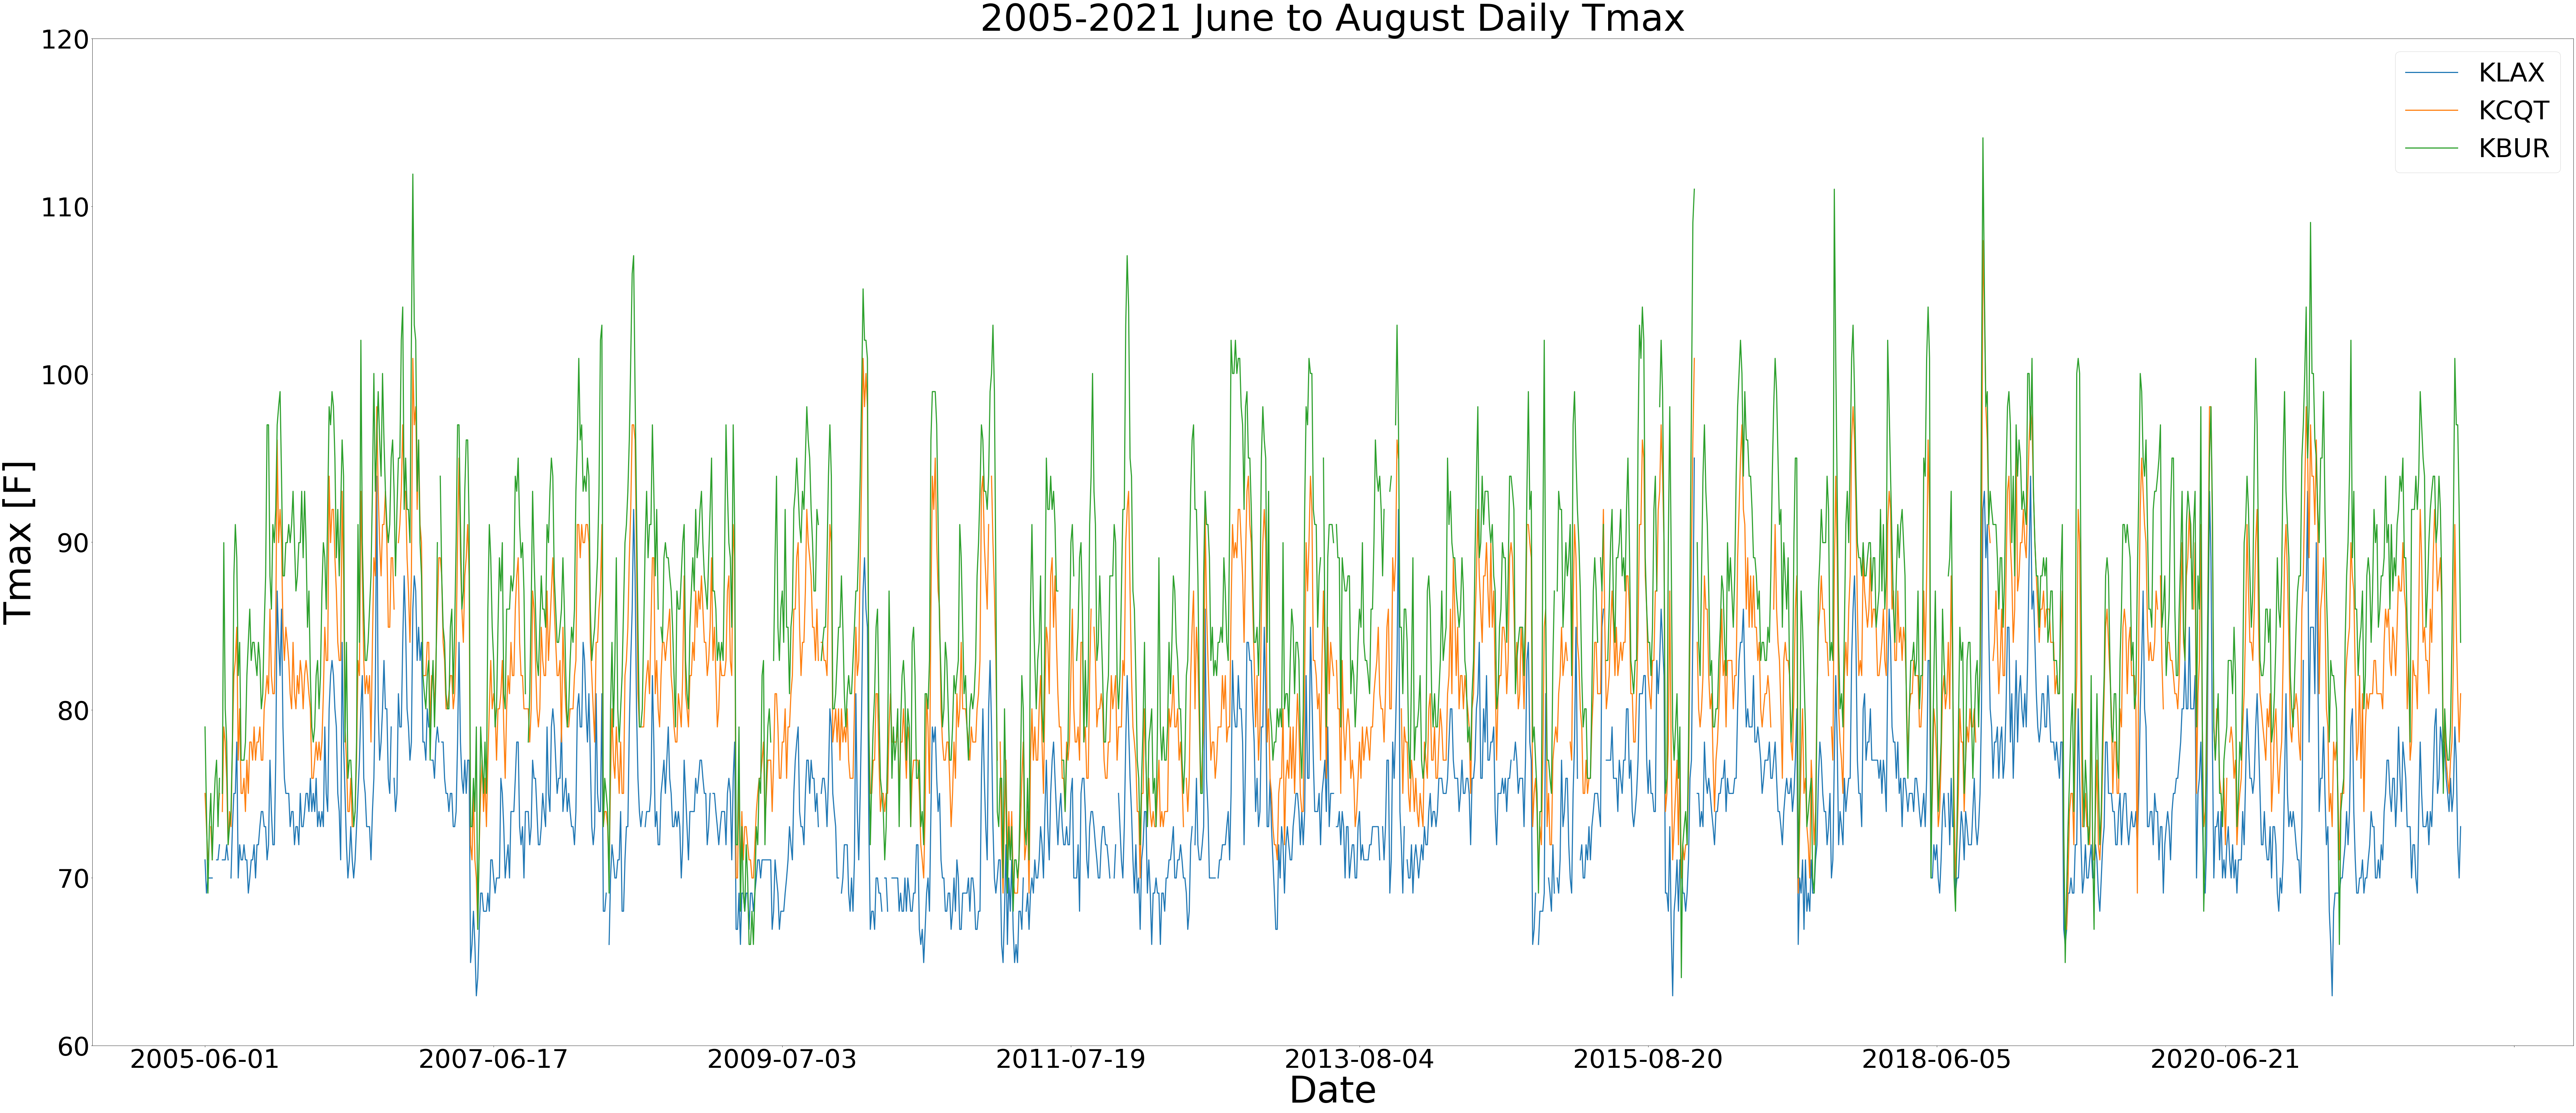

In [7]:
stations = ['KLAX', 'KCQT', 'KBUR']
colors  = ['tab:blue', 'tab:orange', 'tab:green']

# Create an axes object 
axes    = plt.gca()

for (site, color) in zip(stations, colors):
    file = './'+site+'/'+var_folder+'/'+site+'_'+var_name+'_June-July-August_'+str(years[0])+'-'+str(years[-1])+'.csv'
    df  = pd.read_csv(file, usecols=['DateTime', var_name])
    df.plot(x = 'DateTime', y = var_name, kind='line',  linewidth=3.0, label = site, color=color, ax=axes)

plt.title(label = str(years[0])+'-'+str(years[-1])+" June to August Daily "+var_name, fontsize=100)
plt.rcParams['figure.figsize'] = (120, 50)
plt.ylim(60, 120)
plt.legend(prop={'size': 70})
plt.xlabel('Date', fontsize = 100)
plt.ylabel(var_name' [F]', fontsize = 100)
plt.xticks(fontsize = 70)
plt.yticks(fontsize = 70)